# Part 5: Horse Race Prediction
## Evaluation of Model

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC

from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import time
import joblib
import pickle

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [13]:
# Read the train and test files
df_train = pd.read_csv('./data/df_train.csv')
df_test = pd.read_csv('./data/df_test.csv')

In [14]:
# View the shape of the train and test files
print(df_train.shape)
print(df_test.shape)

(23500, 27)
(5864, 27)


In [15]:
# View the first 2 rows of the train file
df_train.head(2)

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,...,running_position_6,race_id,recent_6_runs,recent_ave_rank,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank
0,1,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133,1032,1,-,...,NaN,2014-001,1,1.0,1400,1,1,1,6.052910,7.381862
1,2,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133,1075,13,2,...,NaN,2014-001,2,2.0,1400,0,1,1,5.825153,6.611465


In [16]:
# View the first 2 rows of the test files
df_test.head(2)

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,...,running_position_6,race_id,recent_6_runs,recent_ave_rank,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank
0,1,5.0,POWERMAX,A009,N Callan,R Gibson,126,1124,9,-,...,NaN,2016-328,1/4/3/3,2.7500,1200,1,1,1,6.438751,6.715420
1,2,2.0,BUDDY BUNDY,T157,K K Chiong,D Cruz,127,1193,8,SH,...,NaN,2016-328,2/11/5/2/6/9,6.8125,1200,0,1,1,6.499033,7.381862


In [17]:
# Keep the features we want to train our model on
X_train = df_train[['actual_weight', 'declared_horse_weight',
                    'draw', #'win_odds', 
                    'jockey_ave_rank',
                    'trainer_ave_rank', 'recent_ave_rank', 'race_distance']]

y_train = df_train['HorseWin']

# Keep the features we want to train our model on
X_test = df_test[['actual_weight', 'declared_horse_weight',
                   'draw', #'win_odds',
                   'jockey_ave_rank',
                    'trainer_ave_rank', 'recent_ave_rank', 'race_distance']]
                    
y_test = df_test[['HorseWin', 'HorseRankTop3']]


In [18]:
X_train.shape

(23500, 7)

# Find the feature importances

In [19]:
# Open the pickled models
smote_rfc = joblib.load('./model/smote_rfc_model.pkl')
lgbm = joblib.load('./model/lgbm_model.pkl')

In [20]:
# find feature importance with random forest
def feature_importance(model, X_train, y_train):
    # fit the model
    model.fit(X_train, y_train)

    # get importance
    importance = model[1][1].feature_importances_

    # sort the index of the importance
    sorted_idx = np.argsort(importance)

    # name of the features
    feature_names = X_train.columns[sorted_idx]

    # summarize feature importance with feature names
    for i,v in enumerate(importance[sorted_idx]):
        print('Feature: %s, Score: %.5f' % (feature_names[i],v))

    # plot a barh graph of feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, importance[sorted_idx])
    plt.title('Feature Importance')
    plt.show()

Feature: race_distance, Score: 0.02442
Feature: actual_weight, Score: 0.04041
Feature: draw, Score: 0.04517
Feature: declared_horse_weight, Score: 0.05656
Feature: trainer_ave_rank, Score: 0.08872
Feature: jockey_ave_rank, Score: 0.30290
Feature: recent_ave_rank, Score: 0.44182


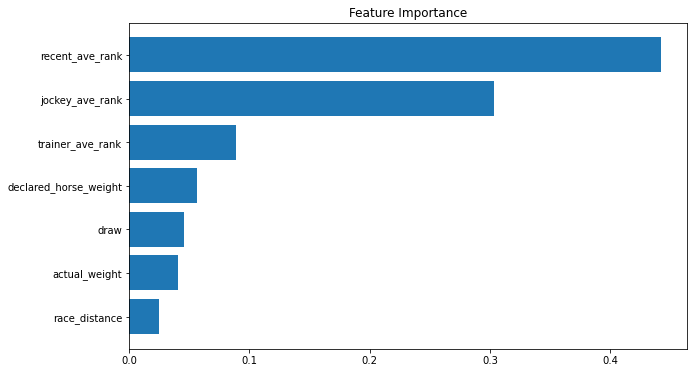

In [21]:
# find feature importance
feature_importance(smote_rfc, X_train, y_train)


## Plot SHAP values

In [22]:
# SHAP values
import shap

# fit the model
lgbm.fit(X_train, y_train)

# Create object that can calculate shap values
explainer = shap.Explainer(lgbm.predict, X_test)

# Calculate Shap values
shap_values = explainer(X_test)

Exact explainer: 5865it [00:52, 90.61it/s]                           


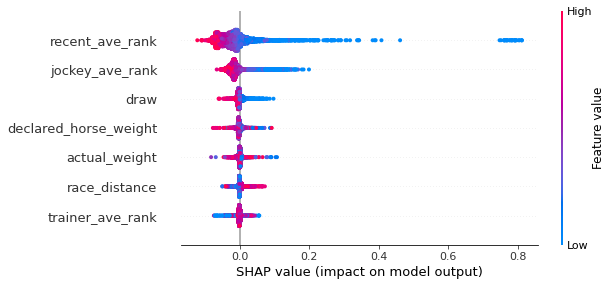

In [23]:
# Plot the SHAP values
shap.plots.beeswarm(shap_values)

The bee swarm plot is used to understand the importance or contribution of features for the whole dataset. Looking at the Recent Average Rank variable, low values (in blue) has a very high contribution towards the prediction. All the little dots represent a single observation. The horizontal axis represents the SHAP value.

All variables are shown in order of global feature importance, the first one being most important and last one being least important.

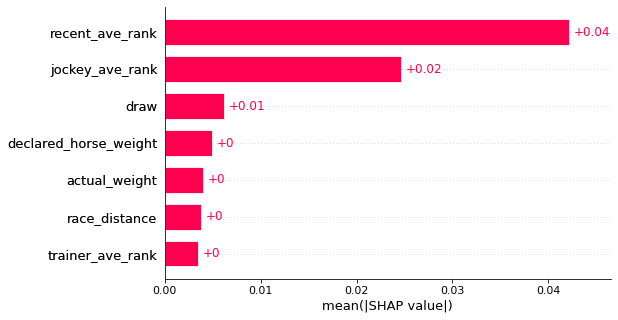

In [24]:

# Plot the SHAP values
shap.plots.bar(shap_values)


In the bar plot, the features are ordered from the highest to lowest effect on prediction. It takes in account the absolute SHAP value, so it does not matter if the feature affects the prediction in a positive or negative way.

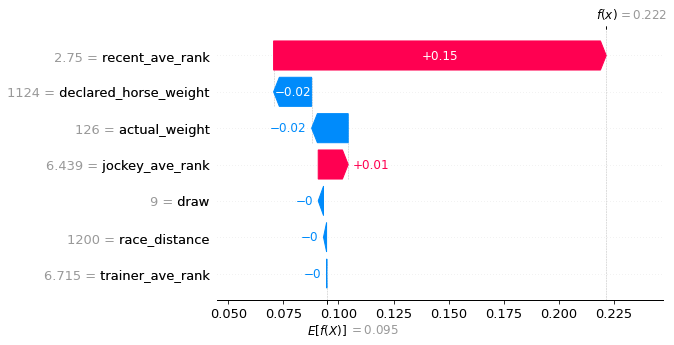

In [25]:

# Plot the SHAP values
shap.plots.waterfall(shap_values[0])

This local plot (a waterfall plot) shows what are the main features affecting the prediction of a single observation, and the magnitude of the SHAP value for each feature. Here we can see how the sum of all SHAP values equals the difference between the prediction and the expected value.